In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re

In [2]:
def extract(Z,SN):
    path = f'./singlestar/Z{Z}_{SN}'
    out = pd.read_csv(f'{path}/sevn_output/output_0.csv')
    evolved = pd.read_csv(f'{path}/sevn_output/evolved_0.dat', sep='\s+').rename(columns = {'#ID':'ID'})
    

    preSN = out[out.RemnantType.shift(-1).eq(6) & out.RemnantType.eq(0)] # only BH
    remnants = out[(out.PhaseBSE == 14) & (out.Mass > 3.)]  # only BH real
    
#     preSN = out[out.RemnantType.shift(-1).ge(4) & out.RemnantType.eq(0) ] # BH and NS
#     remnants = out[(out.Mass < 3.) & ( (out.PhaseBSE == 14))]  # only ppisn derived compact object
    IDs = remnants.ID.values
    progenitors = evolved[evolved.ID.isin(IDs)].sort_values(by='Mass')                 # progenitors
    IDs_sorted = progenitors.ID.values
    
#     if Z == '015':
#         WRBHprogIDs = progenitors[(progenitors.Mass >=18.) & (progenitors.Mass <=54.)].ID.values  #54
#     elif Z=='02':
#         WRBHprogIDs = progenitors[(progenitors.Mass >=18.) & (progenitors.Mass <=48.)].ID.values  #48
#     WRBHprog = progenitors[progenitors.ID.isin(WRBHprogIDs)] 
#     WRBHpreSN = preSN[preSN.ID.isin(WRBHprogIDs)] 
#     WRBHrem = remnants[remnants.ID.isin(WRBHprogIDs)] 
#    return WRBHprog, WRBHpreSN, WRBHrem

    preSN = preSN[preSN.ID.isin(IDs_sorted)] 
    return progenitors, preSN, remnants


def extractHE(Z,SN):
    path = f'./singlestarHE/Z{Z}_{SN}'
    out = pd.read_csv(f'{path}/sevn_output/output_0.csv')
    evolved = out.drop_duplicates(subset = 'ID', keep='first')
    

    #preSN = out[out.RemnantType.shift(-1).ge(4) & out.RemnantType.eq(0)]  # extract preSN before RemType becomes >=4
    #remnants = out[(out.PhaseBSE == 13)| (out.PhaseBSE == 14)]  # SN or BH
#     preSN = out[out.RemnantType.shift(-1).eq(6) & out.RemnantType.eq(0)] # only BH
#     remnants = out[(out.PhaseBSE == 14)]  # only BH
#     IDs = remnants.ID.values
#     progenitors = evolved[evolved.ID.isin(IDs)]                 # progenitors
    
#     if Z == '015':
#         WRBHprogIDs = progenitors[(progenitors.Mass >=3.) & (progenitors.Mass <=30.)].ID.values  #54
#     elif Z=='02':
#         WRBHprogIDs = progenitors[(progenitors.Mass >=3.) & (progenitors.Mass <=30.)].ID.values  #48
#     WRBHprog = progenitors[progenitors.ID.isin(WRBHprogIDs)] 
#     WRBHpreSN = preSN[preSN.ID.isin(WRBHprogIDs)] 
#     WRBHrem = remnants[remnants.ID.isin(WRBHprogIDs)]


    
    remnants = out[(out.PhaseBSE == 14) & (out.Mass > 3.)]  # only BH real
    IDs = remnants.ID.values
    progenitors = evolved[evolved.ID.isin(IDs)]                 # progenitors
    preSN = out[out.RemnantType.shift(-1).eq(6) & out.RemnantType.eq(0)] # only BH
    preSN = preSN[preSN.ID.isin(IDs)] 
    return progenitors, preSN, remnants

# Only up to pre-SN stage

In [3]:
def extractold(Z,SN):
    ### set paths ###
    path_to_sevn_output = f'./singlestar/Z{Z}_{SN}/sevn_output/'
    path_evolved = path_to_sevn_output + 'evolved_0.dat'  # evolved binaries
    path_log = path_to_sevn_output + 'logfile_0.dat'      # logfile
    path_out = path_to_sevn_output + 'output_0.csv'       # output file
    
    ### extract SN events from the logfile ###
    # logfile SN lines have the following structure
    # S;name;ID;SN;time;M_tot:M_He:M_CO:M_rem:rem_type:other_infos_on_natal_kicks
    # where M_tot,M_He,M_CO,M_rem,rem_type are before the SN explosion
    regex_str=r'S;\d+;(\d+);SN;\d+.\d+;(\d+.\d+):(\d+.\d+):(\d+.\d+):(\d+.\d+):(\d+):'
    with open(path_log,"r") as f:
           SN_mask = re.findall(regex_str,f.read())             #Find al the SN occurence and save the ID
    col_names = ['ID','MpreSN','MHe','MCO','Mrem','rem_type']
    SN = pd.DataFrame(SN_mask, columns=col_names,dtype=float)   # convert into pandas dataframe

    ## read evolved and output files ##
    evolved = pd.read_csv(path_evolved, sep='\s+').rename(columns = {'#ID':'ID'}) # contains 'Mass' ZAMS
    
    # progenitors and remnants f stars that explode as SN
    merged = pd.merge(evolved,SN,on='ID')
    merged = merged[merged['rem_type'] >= 4]           # take only NS and BH remnants
    merged = merged.sort_values(by='Mass')    # sort in order to allow plotting and not scattering
    
    return merged

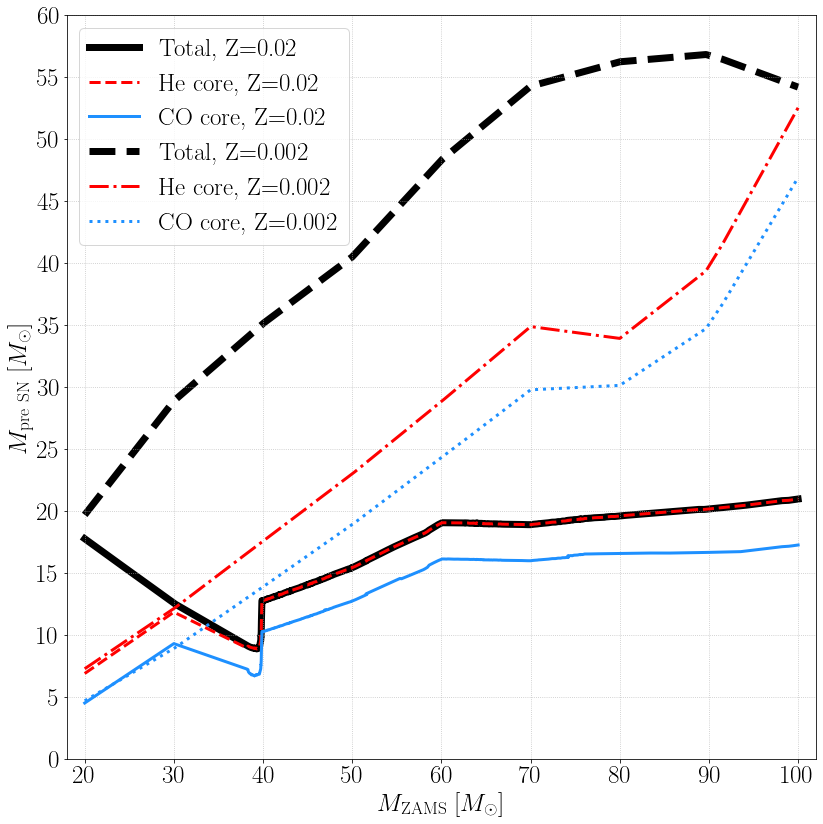

In [4]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})

com02= extractold('02','com')
com02 = com02.loc[(com02.Mass >=20.) & (com02.Mass<=100.)]

com002= extractold('002','com')
com002 = com002.loc[(com002.Mass >=20.) & (com002.Mass<=100.)]

fig = plt.figure(figsize=(12,12))
plt.plot(com02.Mass.values, com02.MpreSN.values, color='k', linewidth=7,label='Total, Z=0.02',zorder=1)
plt.plot(com02.Mass.values, com02.MHe.values, color='r', linewidth=3,linestyle='dashed',label='He core, Z=0.02')
plt.plot(com02.Mass.values, com02.MCO.values, c='dodgerblue',linewidth=3,label='CO core, Z=0.02')


plt.plot(com002.Mass.values, com002.MpreSN.values, color='k',linewidth=7,linestyle='dashed',label='Total, Z=0.002',zorder=1)
plt.plot(com002.Mass.values, com002.MHe.values, color='red', linewidth=3,linestyle='dashdot',label='He core, Z=0.002')
plt.plot(com002.Mass.values, com002.MCO.values, c='dodgerblue',linewidth=3,linestyle='dotted',label='CO core, Z=0.002')
plt.xlim(18,102)
plt.xticks(np.arange(20,101,10))
plt.yticks(np.arange(0,61,5))
plt.xlabel(r'$M_{\rm ZAMS} ~ [M_\odot]$')
plt.ylabel(r'$M_{\rm pre~SN}~[M_\odot]$')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
#fig.savefig('./singlestar/preSN.pdf')

In [5]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 30})

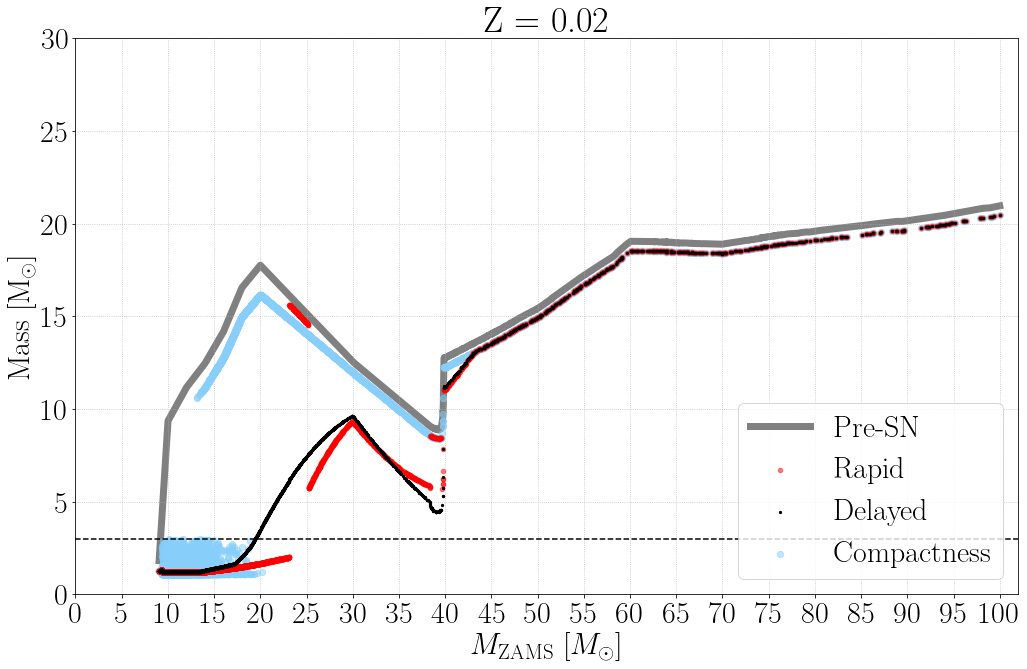

In [16]:
com02= extractold('02','com')
del02= extractold('02','del')
rap02= extractold('02','rap')

com02 = com02.loc[com02.Mass<=100.]
del02 = del02.loc[del02.Mass<=100.]
rap02 = rap02.loc[rap02.Mass<=100.]


fig = plt.figure(figsize=(15,10))
plt.title('Z = 0.02')
plt.plot(com02.Mass.values, com02.MpreSN.values, color='grey', linewidth=7,label='Pre-SN',zorder=1)
plt.scatter(rap02.Mass.values, rap02.Mrem.values, c='r', alpha=0.5, s=20,label='Rapid',zorder=3)
plt.scatter(del02.Mass.values, del02.Mrem.values, c='k', s=5, label='Delayed',zorder=4)
plt.scatter(com02.Mass.values, com02.Mrem.values, c='lightskyblue', alpha=0.5, s=40,label='Compactness',zorder=2)
plt.axhline(3,color='k',linestyle='dashed')

plt.xlim(18,102)
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,31,5))
plt.xlabel(r'$M_{\rm ZAMS} ~ [M_\odot]$')
plt.ylabel(r'$\rm Mass~[M_\odot]$')
plt.legend(loc='lower right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/remnants_Z02.pdf')

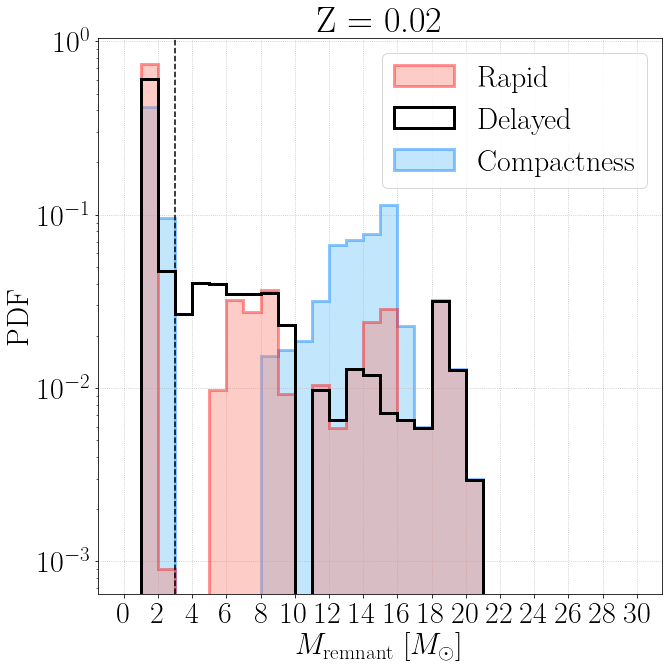

In [15]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02')
xedges = np.arange(0,31,1.)  #35
plt.hist(rap02.Mrem.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3,density=True, zorder=2, label='Rapid')
plt.hist(del02.Mrem.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3, density=True, zorder=3, label='Delayed')
plt.hist(com02.Mrem.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3, density=True, zorder=1,label='Compactness')
plt.axvline(3,color='k',linestyle='dashed')
plt.xlabel(r'$M_{\rm remnant} ~ [M_\odot]$')
plt.ylabel(r'PDF')
plt.xticks(np.arange(0,31,2))
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/hist_Z02.pdf')

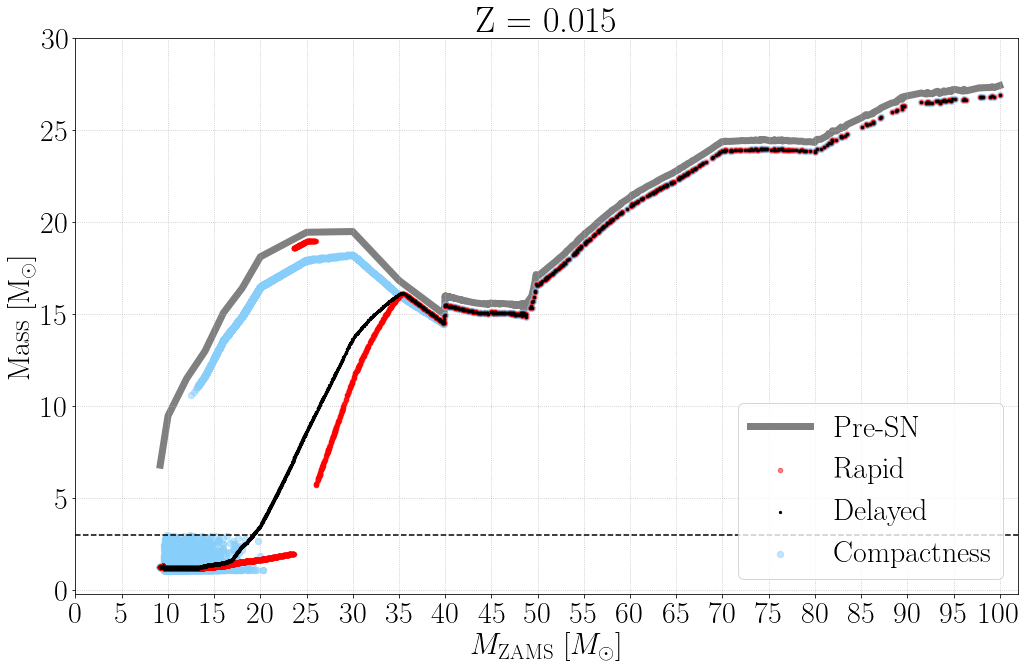

In [13]:
com015= extractold('015','com')
del015= extractold('015','del')
rap015= extractold('015','rap')

com015 = com015.loc[com015.Mass<=100.]
del015 = del015.loc[del015.Mass<=100.]
rap015 = rap015.loc[rap015.Mass<=100.]


fig = plt.figure(figsize=(15,10))
plt.title('Z = 0.015')
plt.plot(com015.Mass.values, com015.MpreSN.values, color='grey', linewidth=7,label='Pre-SN',zorder=1)
plt.scatter(rap015.Mass.values, rap015.Mrem.values, c='r', alpha=0.5, s=20,label='Rapid',zorder=3)
plt.scatter(del015.Mass.values, del015.Mrem.values, c='k', s=5, label='Delayed',zorder=4)
plt.scatter(com015.Mass.values, com015.Mrem.values, c='lightskyblue', alpha=0.5, s=40,label='Compactness',zorder=2)
plt.axhline(3,color='k',linestyle='dashed')

plt.xlim(18,102)
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,31,5))
plt.xlabel(r'$M_{\rm ZAMS} ~ [M_\odot]$')
plt.ylabel(r'$\rm Mass~ [M_\odot]$')
plt.legend(loc='lower right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/remnants_Z015.pdf')

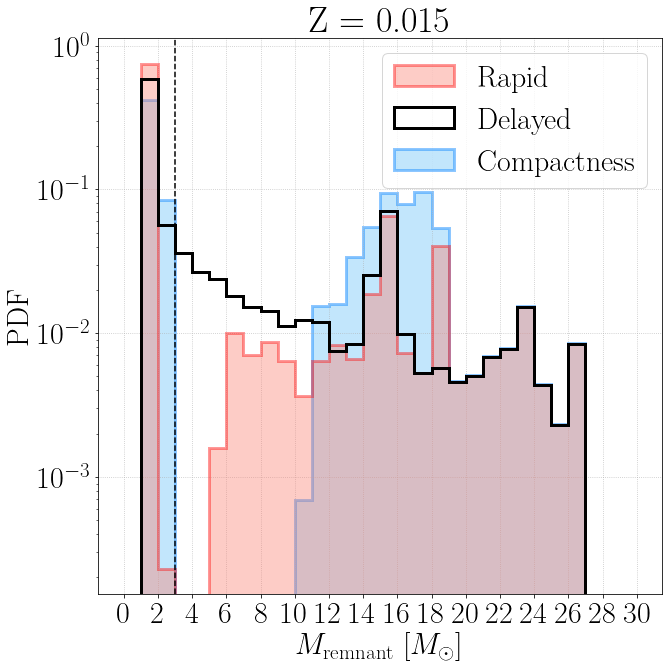

In [14]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015')
xedges = np.arange(0,31,1.)  #35
plt.hist(rap015.Mrem.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3,density=True, zorder=2, label='Rapid')
plt.hist(del015.Mrem.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3, density=True, zorder=3, label='Delayed')
plt.hist(com015.Mrem.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3, density=True, zorder=1,label='Compactness')
plt.axvline(3,color='k',linestyle='dashed')
plt.xlabel(r'$M_{\rm remnant} ~ [M_\odot]$')
plt.ylabel(r'PDF')
plt.xticks(np.arange(0,31,2))
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/hist_Z015.pdf')

# Single star from ZAMS

In [62]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})

In [54]:
prog2r, preSN2r,rem2r = extract('02','rap')
prog2d, preSN2d, rem2d = extract('02','del')
prog2c, preSN2c, rem2c = extract('02','com')

prog15r, preSN15r, rem15r = extract('015','rap')
prog15d, preSN15d, rem15d = extract('015','del')
prog15c, preSN15c, rem15c = extract('015','com')

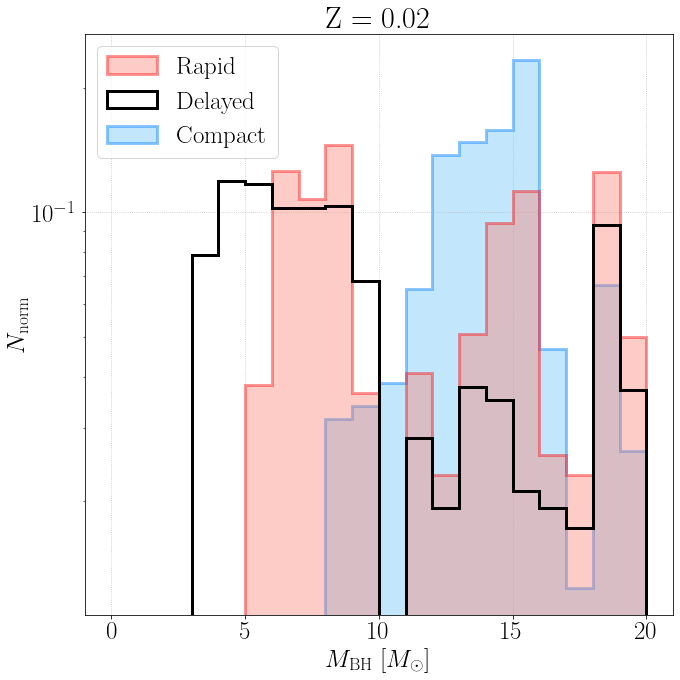

In [69]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02')
xedges = np.arange(0,21,1.)  #35
plt.hist(rem2r.Mass.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3,density=True, zorder=2, label='Rapid')
plt.hist(rem2d.Mass.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3, density=True, zorder=3, label='Delayed')
plt.hist(rem2c.Mass.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3, density=True, zorder=1,label='Compact')
plt.xlabel(r'$M_{\rm BH} ~ [M_\odot]$')
plt.ylabel(r'$N_{\rm norm}$')
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/hist_Z02.pdf')

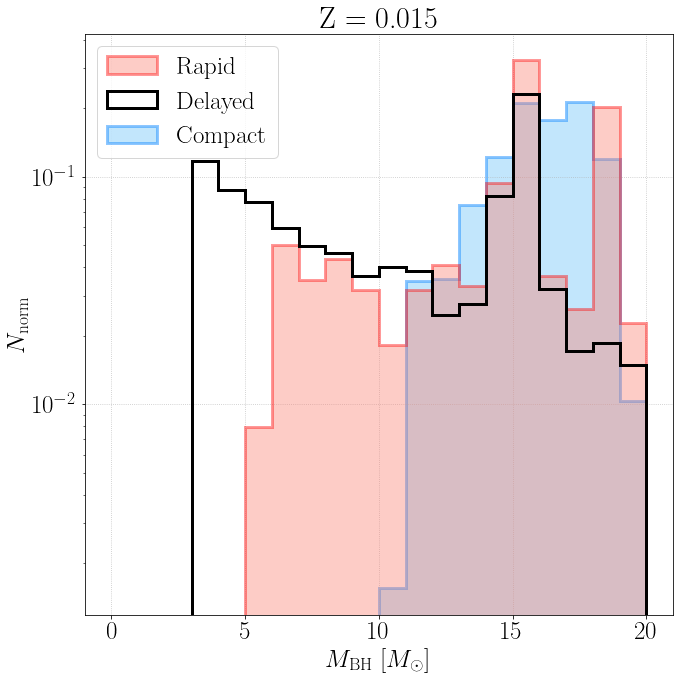

In [70]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015')
xedges = np.arange(0,21,1.)  # 35
plt.hist(rem15r.Mass.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3, density=True, zorder=2, label='Rapid')
plt.hist(rem15d.Mass.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3,density=True, zorder=3, label='Delayed')
plt.hist(rem15c.Mass.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3,density=True,zorder=1,label='Compact')
plt.xlabel(r'$M_{\rm BH} ~ [M_\odot]$')
plt.ylabel(r'$N_{\rm norm}$')
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/hist_Z015.pdf')

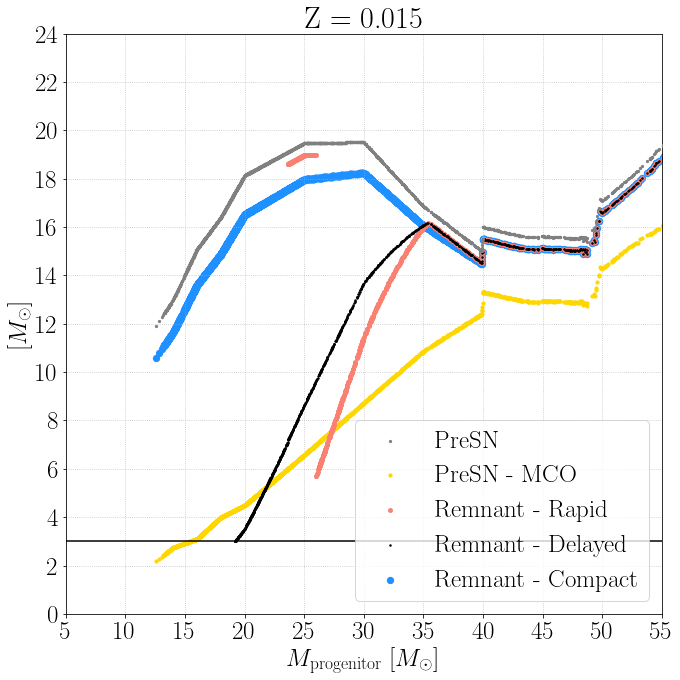

In [11]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015')
plt.scatter(prog15c.Mass.values, preSN15c.Mass.values, c='grey',s=5, zorder=5, label='PreSN')
#plt.scatter(prog15c.Mass.values, preSN15c.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(prog15c.Mass.values, preSN15c.MCO.values, c='gold',s=10, zorder=2, label='PreSN - MCO')
plt.scatter(prog15r.Mass.values, rem15r.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(prog15d.Mass.values, rem15d.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(prog15c.Mass.values, rem15c.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(5,25)
plt.ylim(0,20)
plt.xticks(np.arange(5,56,5))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm progenitor} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='lower right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/progZ015.jpg')

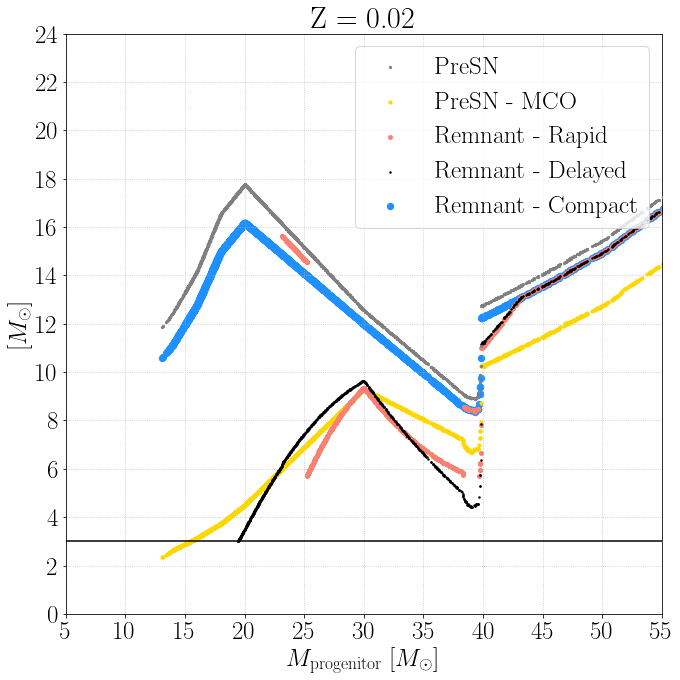

In [12]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02')
plt.scatter(prog2c.Mass.values, preSN2c.Mass.values, c='grey',s=5, zorder=5, label='PreSN')
#plt.scatter(prog2c.Mass.values, preSN2c.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(prog2c.Mass.values, preSN2c.MCO.values, c='gold',s=10, zorder=2, label='PreSN - MCO')
plt.scatter(prog2r.Mass.values, rem2r.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(prog2d.Mass.values, rem2d.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(prog2c.Mass.values, rem2c.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(5,25)
plt.ylim(0,20)
plt.xticks(np.arange(5,56,5))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm progenitor} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestar/progZ02.jpg')

# Single PURE HE star

In [13]:
prog2rHE, preSN2rHE,rem2rHE = extractHE('02','rap')
prog2dHE, preSN2dHE, rem2dHE = extractHE('02','del')
prog2cHE, preSN2cHE, rem2cHE = extractHE('02','com')

prog15rHE, preSN15rHE, rem15rHE = extractHE('015','rap')
prog15dHE, preSN15dHE, rem15dHE = extractHE('015','del')
prog15cHE, preSN15cHE, rem15cHE = extractHE('015','com')

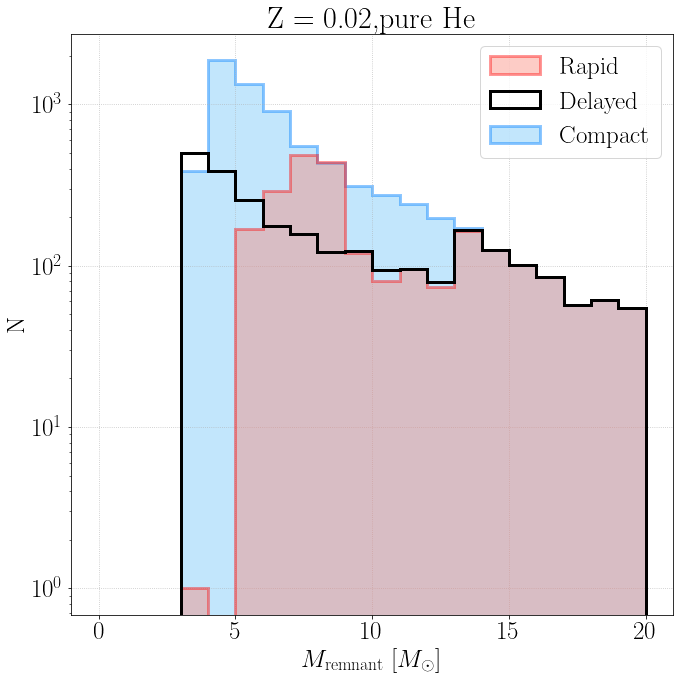

In [18]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02,pure He')
xedges = np.arange(0,21,1.)  # 35
plt.hist(rem2rHE.Mass.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3, zorder=2, label='Rapid')
plt.hist(rem2dHE.Mass.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3,zorder=3, label='Delayed')
plt.hist(rem2cHE.Mass.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3,zorder=1,label='Compact')
plt.xlabel(r'$M_{\rm remnant} ~ [M_\odot]$')
plt.ylabel('N')
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/hist_Z02.jpg')

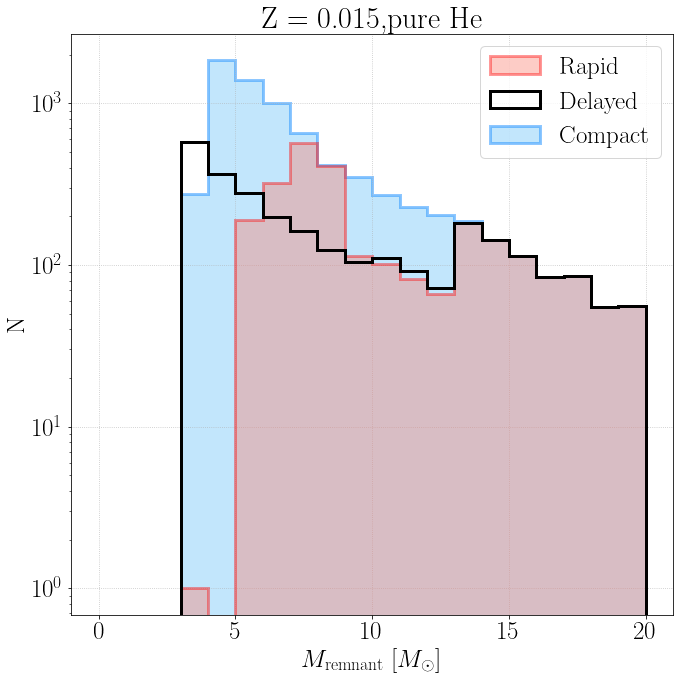

In [17]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015,pure He')
xedges = np.arange(0,21,1.)  # 35
plt.hist(rem15rHE.Mass.values, bins=xedges, fc='salmon', ec='r', alpha=0.4, histtype='stepfilled', lw=3, zorder=2, label='Rapid')
plt.hist(rem15dHE.Mass.values, bins=xedges, fc='None', ec='k',  histtype='stepfilled',lw=3,zorder=3, label='Delayed')
plt.hist(rem15cHE.Mass.values, bins=xedges, fc='lightskyblue', ec='dodgerblue', alpha=0.5, histtype='stepfilled',lw=3,zorder=1,label='Compact')
plt.xlabel(r'$M_{\rm remnant} ~ [M_\odot]$')
plt.ylabel('N')
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/hist_Z015.jpg')

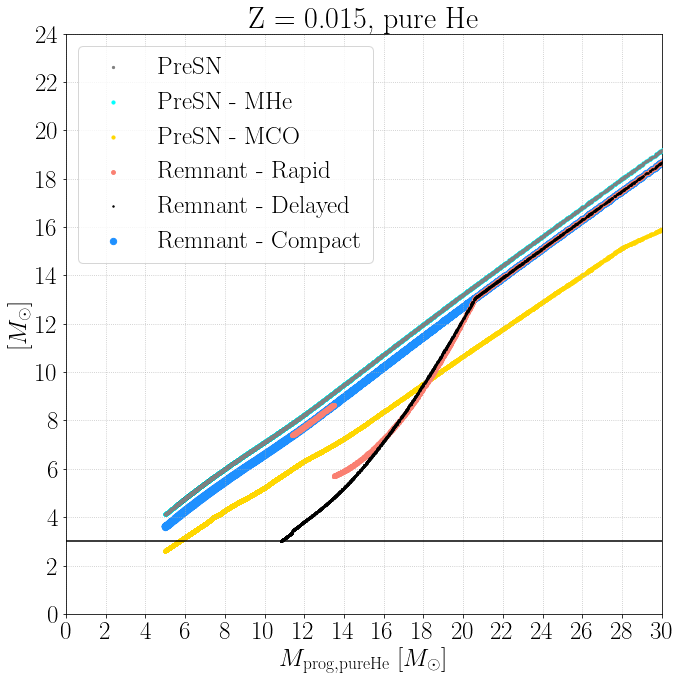

In [14]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015, pure He')
xedges = np.arange(0,35,1.)
plt.scatter(prog15cHE.Mass.values, preSN15cHE.Mass.values, c='grey',s=5, zorder=5, label='PreSN')
plt.scatter(prog15cHE.Mass.values, preSN15cHE.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(prog15cHE.Mass.values, preSN15cHE.MCO.values, c='gold',s=10, zorder=1, label='PreSN - MCO')
plt.scatter(prog15rHE.Mass.values, rem15rHE.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(prog15dHE.Mass.values, rem15dHE.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(prog15cHE.Mass.values, rem15cHE.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(0,25)
plt.ylim(0,20)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm prog, pure He} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/HEprogZ015.jpg')

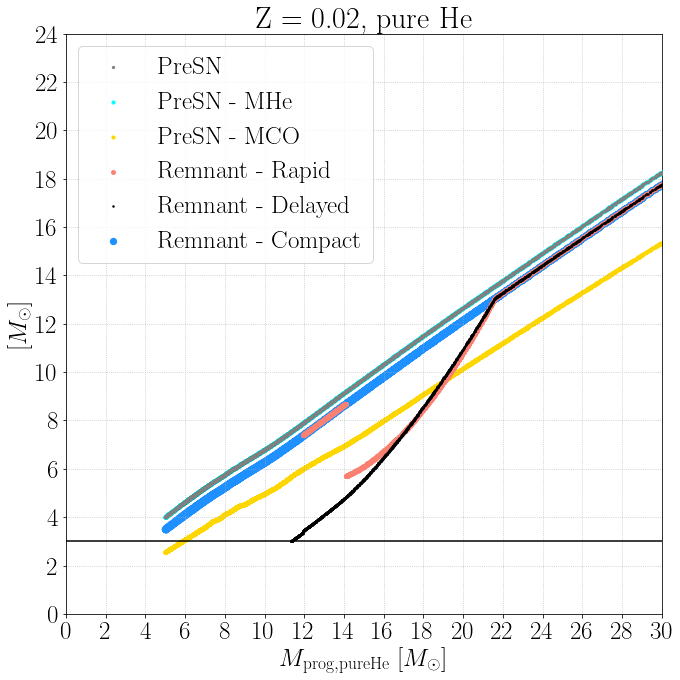

In [15]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02, pure He')
plt.scatter(prog2cHE.Mass.values, preSN2cHE.Mass.values, c='grey',s=5, zorder=5, label='PreSN')
plt.scatter(prog2cHE.Mass.values, preSN2cHE.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(prog2cHE.Mass.values, preSN2cHE.MCO.values, c='gold',s=10, zorder=1, label='PreSN - MCO')
plt.scatter(prog2rHE.Mass.values, rem2rHE.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(prog2dHE.Mass.values, rem2dHE.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(prog2cHE.Mass.values, rem2cHE.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(0,25)
plt.ylim(0,20)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm prog, pure He} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/HEprogZ02.jpg')

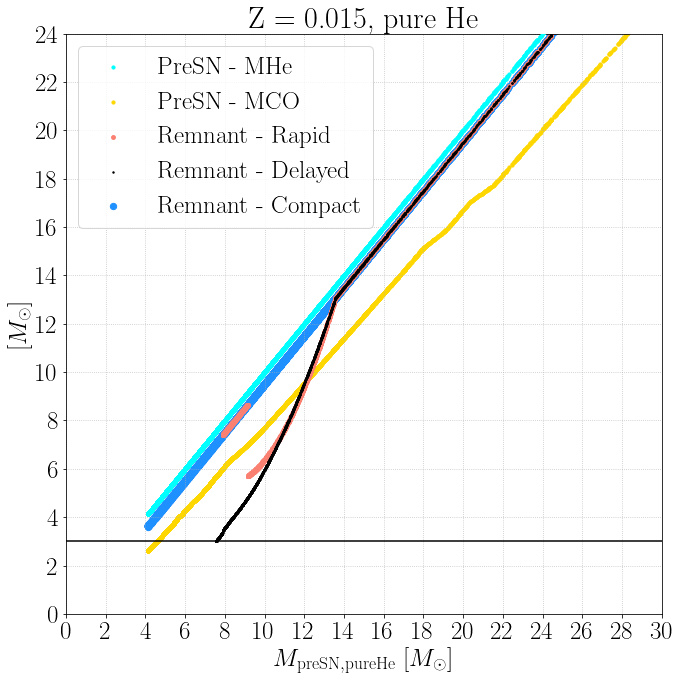

In [29]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.015, pure He')
xedges = np.arange(0,35,1.)
plt.scatter(preSN15cHE.Mass.values, preSN15cHE.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(preSN15cHE.Mass.values, preSN15cHE.MCO.values, c='gold',s=10, zorder=1, label='PreSN - MCO')
plt.scatter(preSN15rHE.Mass.values, rem15rHE.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(preSN15dHE.Mass.values, rem15dHE.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(preSN15cHE.Mass.values, rem15cHE.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(0,25)
plt.ylim(0,20)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm preSN, pure He} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/HEpreSNremZ015.jpg')

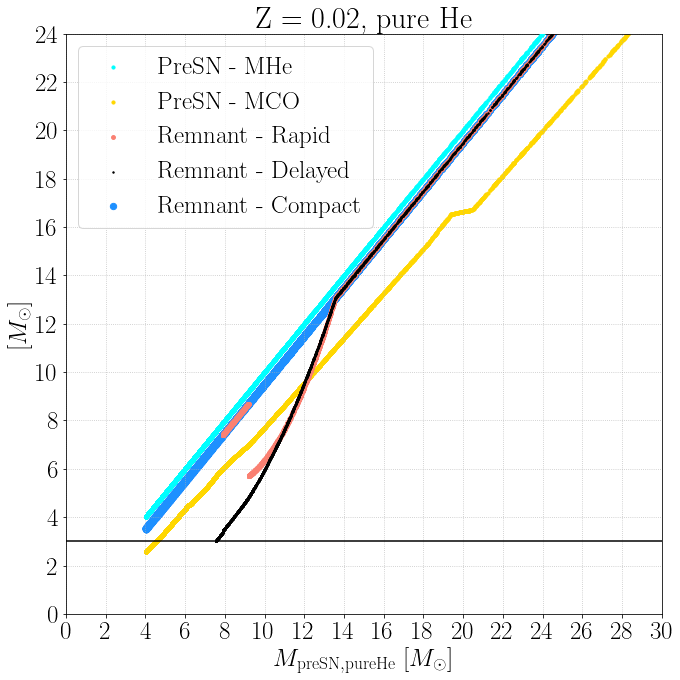

In [30]:
fig = plt.figure(figsize=(10,10))
plt.title('Z = 0.02, pure He')
xedges = np.arange(0,35,1.)
plt.scatter(preSN2cHE.Mass.values, preSN2cHE.MHE.values, c='cyan',s=10, zorder=4, label='PreSN - MHe')
plt.scatter(preSN2cHE.Mass.values, preSN2cHE.MCO.values, c='gold',s=10, zorder=1, label='PreSN - MCO')
plt.scatter(preSN2rHE.Mass.values, rem2rHE.Mass.values, c='salmon',s=15, zorder=2, label='Remnant - Rapid')
plt.scatter(preSN2dHE.Mass.values, rem2dHE.Mass.values, c = 'k', s=2,zorder=3, label='Remnant - Delayed')
plt.scatter(preSN2cHE.Mass.values, rem2cHE.Mass.values, c =  'dodgerblue', s=40,zorder=1,label='Remnant - Compact')
plt.axhline(3, color='k')
plt.xlim(0,25)
plt.ylim(0,20)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.xlabel(r'$M_{\rm preSN, pure He} ~ [M_\odot]$')
plt.ylabel(r'$[M_\odot]$')
plt.legend(loc='upper left')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig('./singlestarHE/HEpreSNremZ02.jpg')